In [2]:
import lal
import torch
import numpy as np
import lalsimulation as lalsim
import matplotlib.pyplot as plt
from phenom_d_og import IMRPhenomD as IMRPhenomD_og
from phenom_d_sub import IMRPhenomD as IMRPhenomD_sub
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 14,
    "legend.title_fontsize": 16,
    "figure.titlesize": 22,
    "axes.labelpad": 10.0,
}
plt.rcParams.update(params)

In [3]:
"""Testing near the extremes on which the LAL implementation is reviewed"""

m1 = 10
m2 = 30
chi1 = torch.tensor([0.9])
chi2 = torch.tensor([0.9])
dist_mpc = torch.tensor([440.0])

# Frequency grid
T = 16
f_l = 16
f_sampling = 4096
# f_u = f_sampling // 2
f_u = 1024
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [4]:
m1_msun = m1
m2_msun = m2
chirp_mass = torch.tensor([mchirp_from_mass1_mass2(m1_msun, m2_msun)])
q = torch.tensor([q_from_mass1_mass2(m1_msun, m2_msun)])
tc = 0.0
phic = torch.tensor([0.0])
inclination = torch.tensor([np.pi / 2.0])
m1_kg = m1 * lal.MSUN_SI
m2_kg = m2 * lal.MSUN_SI
distance = dist_mpc.item() * 1e6 * lal.PC_SI
fs_torch = torch.arange(f_l, f_u, df)[1:]

hp_og, hc_og = IMRPhenomD_og(
    fs_torch, chirp_mass, q, chi1, chi2, dist_mpc, phic, inclination, f_ref
)

hp_sub, hc_sub = IMRPhenomD_sub(
    fs_torch, chirp_mass, q, chi1, chi2, dist_mpc, phic, inclination, f_ref
)

hp_og = hp_og[0].numpy()
hc_og = hc_og[0].numpy()
hp_sub = hp_sub[0].numpy()
hc_sub = hc_sub[0].numpy()

In [5]:
IMRphenom = "IMRPhenomD"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

hp_lal, hc_lal = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1.item(),
    0.0,
    0.0,
    chi2.item(),
    distance,
    inclination.item(),
    phic.item(),
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    None,
    approximant,
)

freqs_lal = np.arange(len(hp_lal.data.data)) * df
mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
f = freqs_lal[mask_lal]
hp_lalsuite = hp_lal.data.data[mask_lal]
hc_lalsuite = hc_lal.data.data[mask_lal]

In [6]:
diff_lal_og = np.maximum(np.abs(hp_lalsuite - hp_og), np.abs(hc_lalsuite - hc_og))
diff_lal_sub = np.maximum(np.abs(hp_lalsuite - hp_sub), np.abs(hc_lalsuite - hc_sub))

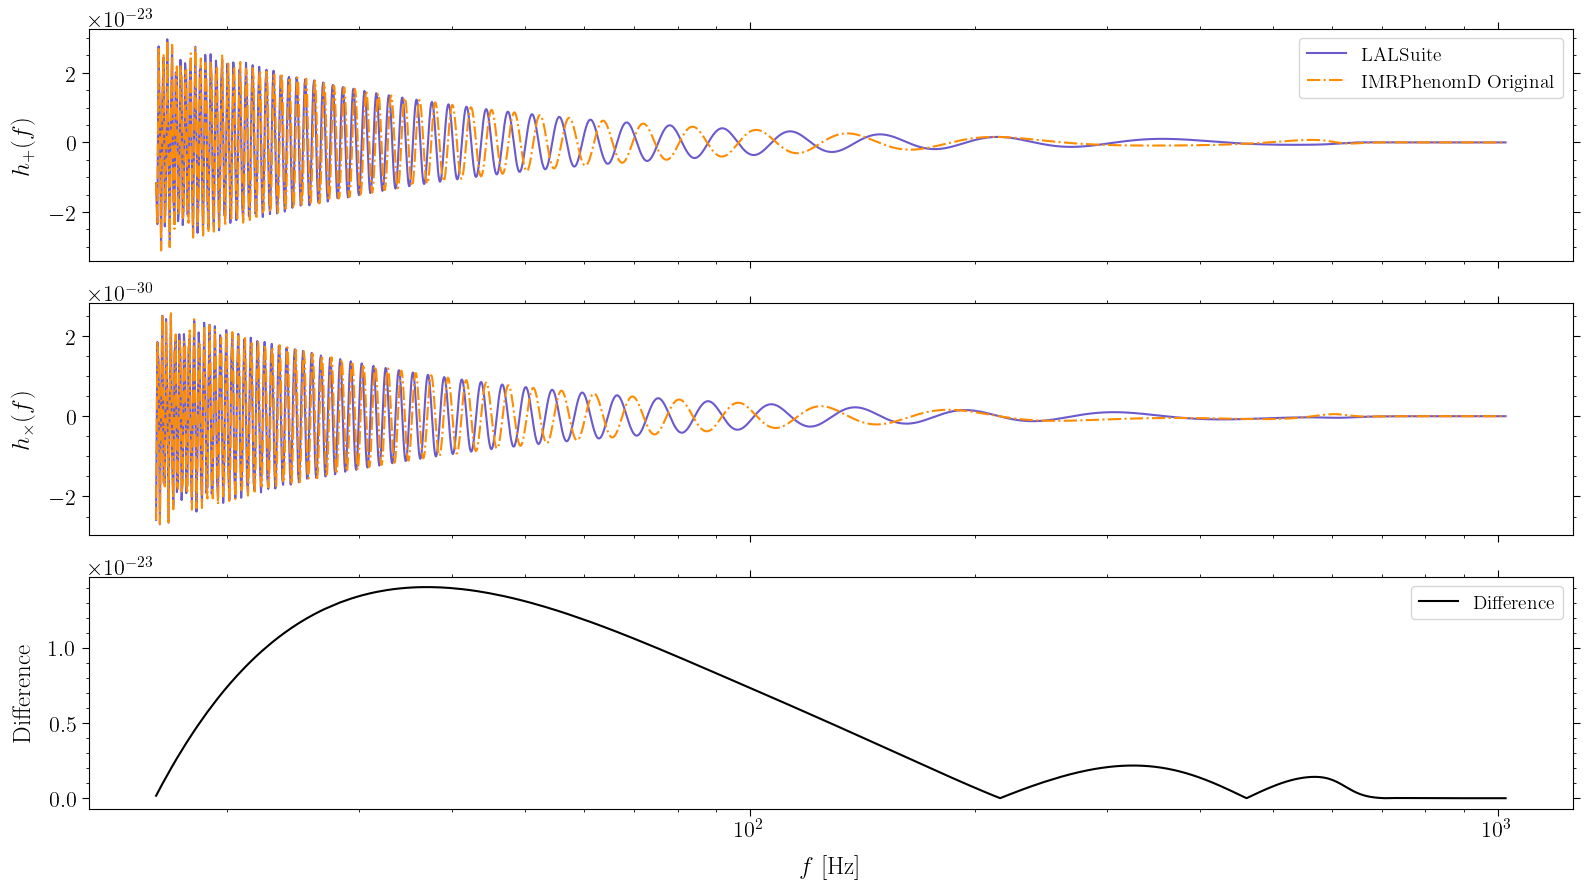

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_lalsuite.real, label="LALSuite", color="slateblue")
ax[0].plot(f, hp_og.real, label="IMRPhenomD Original", color="darkorange", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_lalsuite.real, label="LALSuite", color="slateblue")
ax[1].plot(f, hc_og.real, label="IMRPhenomD Original", color="darkorange", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_lal_og, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

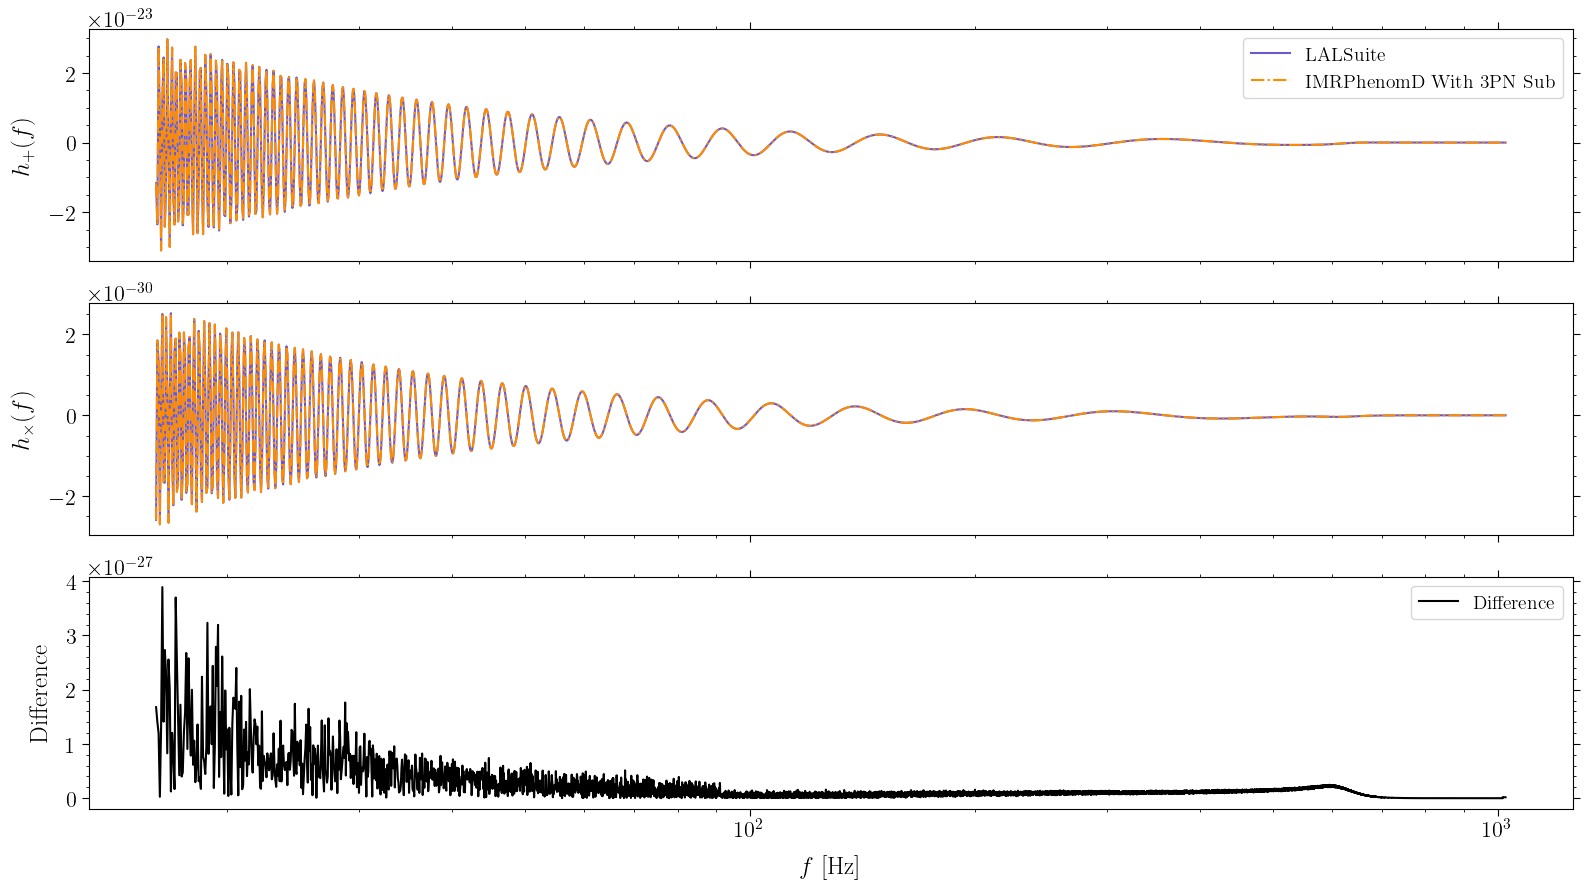

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_lalsuite.real, label="LALSuite", color="slateblue")
ax[0].plot(f, hp_sub.real, label="IMRPhenomD With 3PN Sub", color="darkorange", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_lalsuite.real, label="LALSuite", color="slateblue")
ax[1].plot(f, hc_sub.real, label="IMRPhenomD With 3PN Subtracted", color="darkorange", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_lal_sub, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

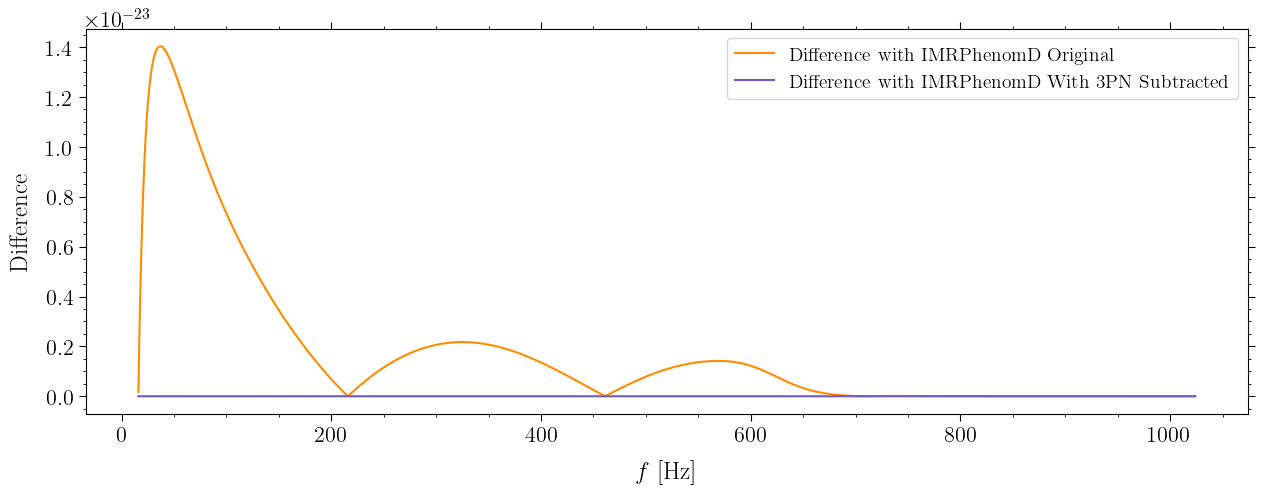

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

ax.plot(f, diff_lal_og, label="Difference with IMRPhenomD Original", color="darkorange")
ax.plot(f, diff_lal_sub, label="Difference with IMRPhenomD With 3PN Subtracted", color="slateblue")
ax.set_ylabel(r"Difference")
ax.set_xlabel(r"$f$ [Hz]")
ax.legend()
plt.show()